[Topic Modelling and Word Embeddings: How to Create a Topic Model and visualize data](Topic-Modelling-and-Word-Embeddings:-How-to-Create-a-Topic-Model-and-visualize-data)


1. [Import Data](#Import-Data)  
2. [Preprocessing: Cleaning Data](#Preprocessing:-Cleaning-Data)     
      a. [Getting Word Counts](#Getting-Word-Counts)    
      b. [Exploration of the data set using Ngrams](#Exploration-of-the-data-set-using-Ngrams)      
3. [Word Embeddings](#Word-Embeddings)    
      a.[Word2Vec](#Word2Vec)   
      b.[t-SNE](#t-SNE)
4.[Topic Modeling](#Topic-Modeling)              
5.[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation-(LDA))  
6.[Non-negative Matrix Factorization (NMF)](#Non-negative-Matrix-Factorization-(NMF))
5. [Vizualisation using Wordcloud](#Vizualisation-using-Wordcloud)    
      a. [For LDA Topics](#For-LDA-Topics)   
      b. [For NMF Topics](#For-NMF-Topics)   
6. [Challenge](#Challenge)         
   

# Topic Modelling and Word Embeddings: How to Create a Topic Model and visualize data

There are numerous steps that can be taken to help put all text on equal footing, many of which involve the comparatively simple ideas of substitution or removal. They are, however, no less important to the overall process. 

Let's go through the different steps we have to take when working on our corpus and we are hoping to understand it. 


## Import Data

I've included an excerpt from [News Category Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset/versions/2/data) in the Data Folder as well! This file is called `News_Category_Dataset_v2.json`.   


In [1]:
import sys
!{sys.executable} -m spacy download en_core_web_sm
import re, numpy as np, pandas as pd
from pprint import pprint

from IPython.display import Image
from IPython.display import display
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize;

import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
from nltk import FreqDist 
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

#suppress all warnings with this
import warnings
warnings.filterwarnings("ignore")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import re, nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/melissangamini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/melissangamini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Spacy for preprocessing
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

In [4]:
import pandas as pd
#df = pd.read_csv('merged_songs.csv')
# import data
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
df.head(3)
print("the shape of the dataframe is ", df.shape)

the shape of the dataframe is  (200853, 6)



[jupyter and pandas display](http://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/) is a good resource to help use jupyters display with pandas to the fullest.

## Preprocessing: Cleaning Data

There are numerous osteps that can be taken to help put all text on equal footing, many of which involve the comparatively simple ideas of substitution or removal. They are, however, no less important to the overall process. These include:   

* set all characters to lowercase
* remove punctuation (generally part of tokenization, but still worth keeping in mind at this stage, even as confirmation)
* remove numbers (or convert numbers to textual representations)
* strip white space (also generally part of tokenization)
* remove default stop words (general English stop words)

But sometimes, it also involves understanding the data and figuring out what we can keep and what we can get rid of. 

In [5]:
df.head(2)

category                                           headline  \
0          CRIME  There Were 2 Mass Shootings In Texas Last Week...   
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   

           authors                                               link  \
0  Melissa Jeltsen  https://www.huffingtonpost.com/entry/texas-ama...   
1    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   

                                   short_description       date  
0  She left her husband. He killed their children... 2018-05-26  
1                           Of course it has a song. 2018-05-26

In [6]:
df['short_description'].head(2)

0    She left her husband. He killed their children...
1                             Of course it has a song.
Name: short_description, dtype: object

#for automatic linebreaks and multi-line cells.
pd.set_option('display.max_colwidth', -1)

In [7]:
#suppress all warnings with this
import warnings
warnings.filterwarnings("ignore")

In [8]:
df['short_description'].head(1)

0    She left her husband. He killed their children...
Name: short_description, dtype: object

The dataset as you have news headline based on section types such as crime news headline or politics. The next will identify how many news headlines found for each section. Below I will show the formula used to count the news headline based on the section. The values of news headlines vary to the section. 

The next step will identify the highest three sections in terms of the amount news headline contain. 


In [9]:
df.rename(columns = {'category':'Section'}, inplace = True)

In [10]:
# Counting how many headline each section have 
df_section_type = df.groupby('Section').count()['headline'].reset_index()
df_section_type

Section  headline
0             ARTS      1509
1   ARTS & CULTURE      1339
2     BLACK VOICES      4528
3         BUSINESS      5937
4          COLLEGE      1144
5           COMEDY      5175
6            CRIME      3405
7   CULTURE & ARTS      1030
8          DIVORCE      3426
9        EDUCATION      1004
10   ENTERTAINMENT     16058
11     ENVIRONMENT      1323
12           FIFTY      1401
13    FOOD & DRINK      6226
14       GOOD NEWS      1398
15           GREEN      2622
16  HEALTHY LIVING      6694
17   HOME & LIVING      4195
18          IMPACT      3459
19   LATINO VOICES      1129
20           MEDIA      2815
21           MONEY      1707
22       PARENTING      8677
23         PARENTS      3955
24        POLITICS     32739
25    QUEER VOICES      6314
26        RELIGION      2556
27         SCIENCE      2178
28          SPORTS      4884
29           STYLE      2254
30  STYLE & BEAUTY      9649
31           TASTE      2096
32            TECH      2082
33   THE WORLDPOST      3664
34          TRAVEL      9887
35        WEDDINGS      3651
36      WEIRD NEWS      2670
37        WELLNESS     17827
38           WOMEN      3490
39      WORLD NEWS      2177
40       WORLDPOST      2579

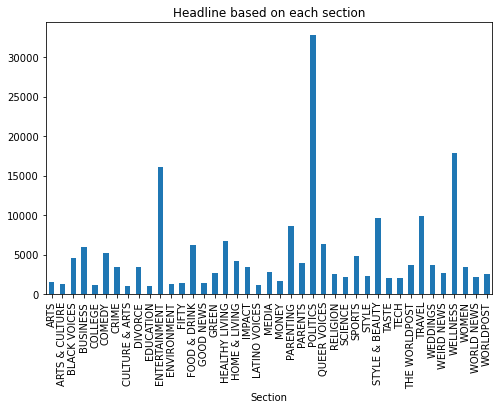

In [11]:
# Section distribution
ax = df.groupby("Section").count()["headline"].plot(kind="bar", 
                                                 figsize=(8, 5),
                                                 title="Headline based on each section")
plt.show()

The __highest three sections__:  
* politics, 
* entertainment
* Wellness

But Because of their size I will choose some of the lowest sections to continue in class, but do so again with the Highest Three Sections. 
* education
* culture & arts
* arts
* food & drink 
* black voices 
* style 
* home & living 
* healthy linving

Based on the chart above will subset the dataset to keep news headlines of the highest three category news headlines, which in our case of the highest are Politics, entertainment, and Wellness. Suggesting the data and leaving three categories is getting the highest news headline to get a better result for the model and remove more noises.

For your challenge, you will be using thesse Categories

But as I mentioned above, so we can accomplish most of what we need in class, I will be choosing some other categories. 

In [12]:
#The highest three sections
#df = df[df["Section"].isin(['ENTERTAINMENT','POLITICS','WELLNESS'])]
#The lowest and diversesections
df = df[df["Section"].isin(['EDUCATION','CULTURE & ARTS','ARTS','FOOD & DRINK',
                          'BLACK VOICES','STYLE','HOME & LIVING','HEALTHY LIVING' ]) ]

### Getting Word Counts

In [13]:
df['Nbr_words_headline'] = df['headline'].apply(lambda x:len(str(x).split()))
df['Nbr_words_description'] = df['short_description'].apply(lambda x:len(str(x).split()))

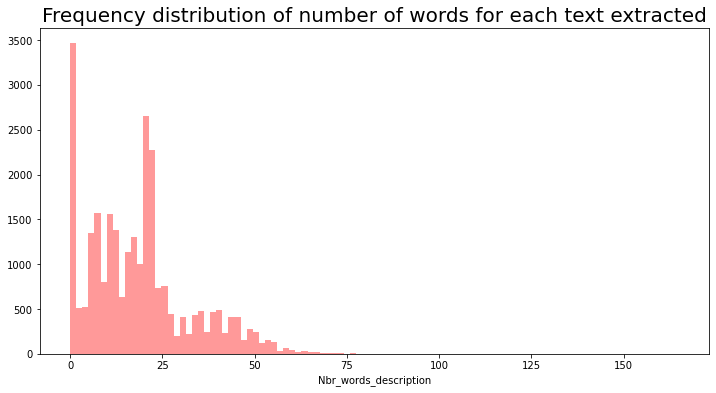

In [14]:
plt.figure(figsize=(12,6))
sns.distplot(df['Nbr_words_description'],kde = False,color="red", bins = 100)
plt.title("Frequency distribution of number of words for each text extracted", size=20)
plt.show()

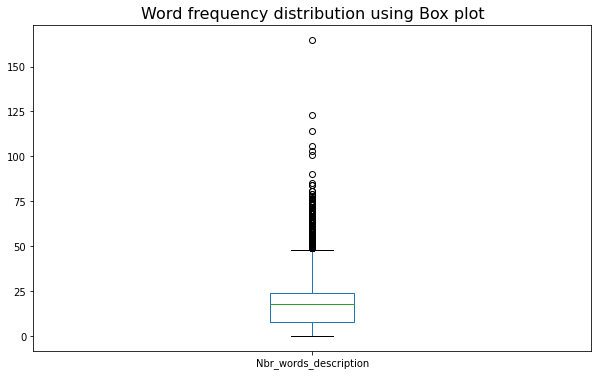

In [15]:
plt.figure(figsize = (10,6))
df['Nbr_words_description'].plot(kind="box")
plt.title("Word frequency distribution using Box plot", size = 16)
plt.show()

In [16]:
#Here we clean the headlines and short description by removing all the  punctuation, 
#removing all that is unnecessary.
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean

df['headline_cleaned'] = df['headline'].apply(cleaned_text)

df['short_description_cleaned'] = df['short_description'].apply(cleaned_text)


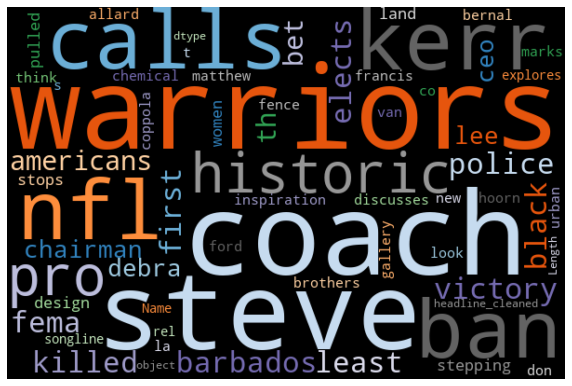

In [17]:
cloud=WordCloud(colormap='tab20c',width=600,height=400).generate(str(df["headline_cleaned"]))
fig=plt.figure(figsize=(10,15))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.show()

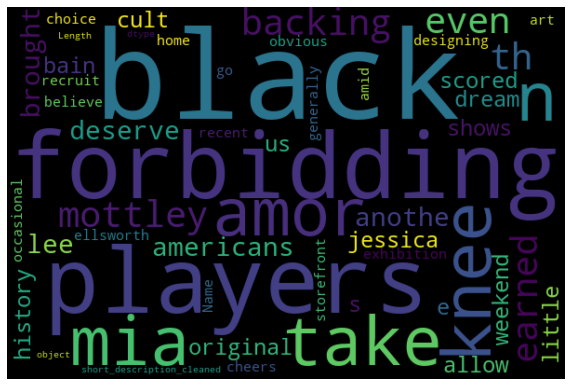

In [18]:
cloud=WordCloud(colormap='viridis',width=600,height=400).generate(str(df["short_description_cleaned"]))
fig=plt.figure(figsize=(10,15))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.show()

From this point I will be focusing on the News Headlines to do our data Analysis on it.
We will be:
* removing stopwords
* tokenizing 
* lemmatizing 

In [19]:
## remove stopwords
stop=stopwords.words('english')
df["stop_removed_headline"]=df['headline_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [20]:
df["tokenized"]=df["stop_removed_headline"].apply(lambda x: nltk.word_tokenize(x))

In [21]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df["lemmatized"]=df["tokenized"].apply(lambda x: word_lemmatizer(x))
df["lemmatize_joined"]=df["lemmatized"].apply(lambda x: ' '.join(x))

In [22]:
df['Number_of_words_for_cleaned'] = df['lemmatize_joined'].apply(lambda x:len(str(x).split()))

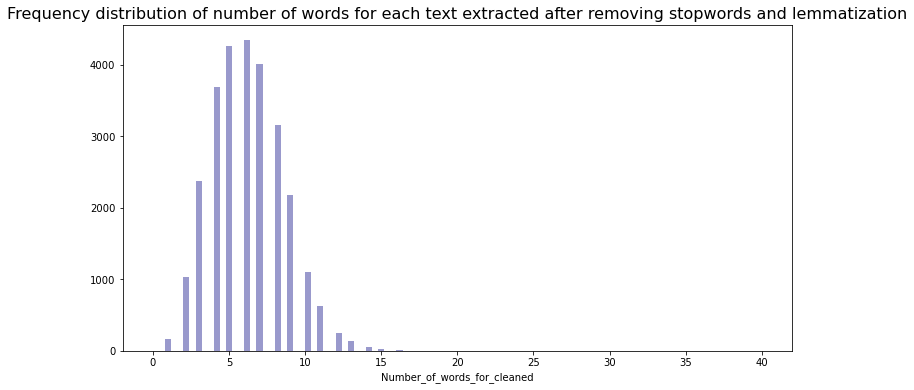

In [23]:
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words_for_cleaned'],kde = False, color= "navy", bins = 100)
plt.title("Frequency distribution of number of words for each text extracted after removing stopwords and lemmatization", size=16)
plt.show()

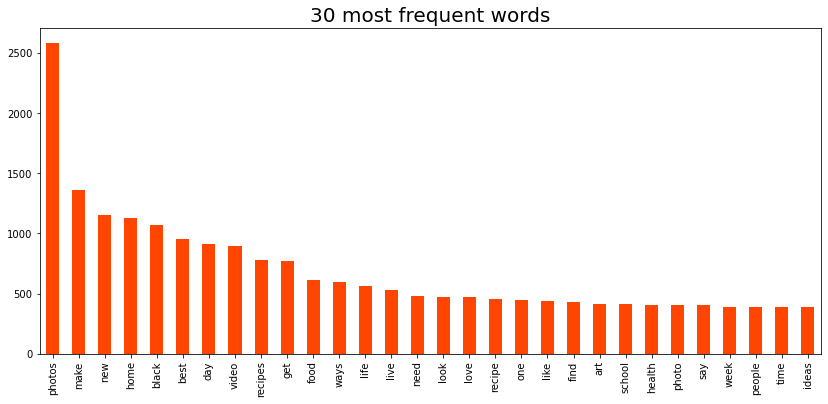

In [24]:
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(df["lemmatize_joined"]).split()).value_counts()[:30]
freq.plot(kind="bar", color = "orangered")
plt.title("30 most frequent words",size=20)
plt.show()

## Exploration of the data set using Ngrams

### Ngrams

Ngrams are defined as contiguous sequences of n words. If the number of words has the same meaning as New York , it's called Bigram, and if it's more than two words, then it's considered as a trigram. Figure 12 is considered in Ngram as unigrams, which is only one word.

In [25]:
import plotly.graph_objects as go

In [26]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['headline'], 20)

df1 = pd.DataFrame(common_words, columns = ['headline' , 'count'])

fig = go.Figure([go.Bar(x=df1['headline'], y=df1['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 words in news_headline before removing stop words"))
fig.show()

In [27]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df["headline"], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the news headline text after removing stop words and lemmatization"))
fig.show()

The chart above shows the top 20 bigrams in the news headline, which is the most frequent words after removing stop words and lemmatization. Comparing the 2 figures, we can see the words more meaningful and not repeated twice, such `new york`, mentioned as one word and `recipe day` as one word. Using bigrams shows to improve our data retrieval to be more meaningful, which in later stage helps to improve the quality of our result.

In [28]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df["headline"], 20)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 trigrams in the news headline"))
fig.show()

The figure above shows the result of pulling the trigrams as top 20 occurring from our news dataset. Some of the text showing in the graph does not make sense to be as three words—our observation showing that Bigrams could more useful to use for our dataset.

In the last stage of our exploration, we used an entity named recognition to understand more about our data. The technique considered to be an information extraction method in which entities that are present in the text are classified into entity types such as place or organization etc. After running this model will understand the type of entities mentioned in our dataset.

In [29]:
# do not run the below code in class as it makes too much time

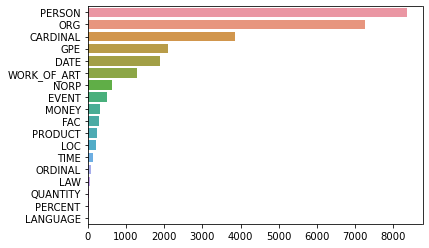

In [30]:
def plot_named_entity_barchart(text):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    
    x,y=map(list,zip(*count))
    sns.barplot(x=y,y=x)

plot_named_entity_barchart(df['headline'])

The chart shows that PERSON entity is the highest which consider most of the names of people mentioned. The second highest in the ORG, which is short of an organization that was mentioned in the text.

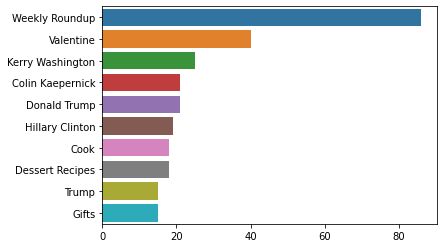

In [31]:
## Find the most recurring person in the data set
def ner(text,ent="PERSON"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe=df['headline'].apply(lambda x: ner(x))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)
plt.show()

The chart shows that `Kerry Washington`, the most person mentioned in our dataset, with `Colin Kaepernick`, `Donald Trump` and `Hillary Clinton` following behind. 
However, we do see that our function did find `Weekly Roundup` and `Valentine` as the Top person, that is most likely because of the writing and the positioning of those words in the headlines. 

<AxesSubplot:>

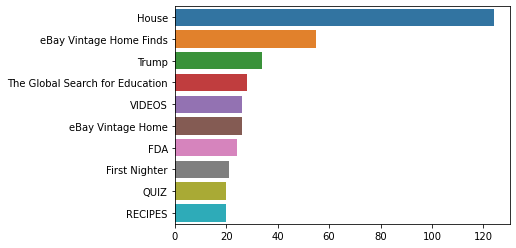

In [32]:
## Find the most organisation in the data set 
def ner(text,ent="ORG"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe=df['headline'].apply(lambda x: ner(x))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)
plt.show()

## Word Embeddings

## Word2Vec
Word2vec is a two-layer neural net that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus. While Word2vec is not a deep neural network, it turns text into a numerical form that deep neural networks can understand.

Word2vec’s applications extend beyond parsing sentences in the wild. It can be applied just as well to genes, code, likes, playlists, social media graphs and other verbal or symbolic series in which patterns may be discerned.

Why? Because words are simply discrete states like the other data mentioned above, and we are simply looking for the transitional probabilities between those states: the likelihood that they will co-occur.

The purpose and usefulness of Word2vec is to group the vectors of similar words together in vectorspace. That is, it detects similarities mathematically. Word2vec creates vectors that are distributed numerical representations of word features, features such as the context of individual words. It does so without human intervention.

Given enough data, usage and contexts, Word2vec can make highly accurate guesses about a word’s meaning based on past appearances. Those guesses can be used to establish a word’s association with other words (e.g. “man” is to “boy” what “woman” is to “girl”), or cluster documents and classify them by topic. Those clusters can form the basis of search, sentiment analysis and recommendations in such diverse fields as scientific research, legal discovery, e-commerce and customer relationship management.

The output of the Word2vec neural net is a vocabulary in which each item has a vector attached to it, which can be fed into a deep-learning net or simply queried to detect relationships between words.

Want to find out more? [Click here:](https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1)


In [33]:
all_words = df["lemmatize_joined"].apply(lambda x: nltk.word_tokenize(x))

In [34]:
w2v_model = Word2Vec(all_words,
                     min_count=600,
                     window=10,
                     #size=250,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed = 42)

In [35]:
w2v_model.wv.index_to_key

['photos',
 'make',
 'new',
 'home',
 'black',
 'best',
 'day',
 'video',
 'recipes',
 'get',
 'food']

Now let's see the vector representation of the word `recipes`.

In [36]:
v1 = w2v_model.wv['recipes']
print(v1)

[-1.00695752e-02 -3.13895405e-03  4.85655473e-04  9.05677024e-03
  4.68817027e-03  6.40863972e-03  7.39199808e-04 -7.77701894e-03
 -2.33301218e-03  9.66133084e-03 -9.37905814e-03  8.95089004e-03
  3.98401031e-03 -4.49244352e-03  6.17353898e-03  7.64941191e-03
 -9.62643977e-03 -9.25836340e-03  2.99072242e-03  9.95090138e-03
 -1.05888015e-02  2.83747260e-03 -7.24553596e-03  3.90954269e-03
  3.84708657e-03 -9.41281766e-03  3.27092828e-03  7.90288113e-03
  7.40782591e-03 -9.59174894e-03 -5.15574729e-03 -5.93672041e-03
 -1.77714461e-03 -7.27092987e-03  7.25433324e-03  5.57372952e-03
  7.49133062e-03 -7.15091405e-03 -1.06713800e-02  9.32239369e-03
 -3.58323590e-03  3.37374071e-03  8.25508777e-03 -1.01141948e-02
 -9.27458610e-03 -1.05278138e-02 -7.33101368e-03 -8.60683993e-03
  7.29655242e-03  1.27609458e-03  1.08424267e-02  5.33333886e-03
  9.38680675e-03 -5.33844158e-03 -3.98074370e-03  7.62264198e-03
 -5.60004171e-03 -8.76856688e-03  3.21267103e-03  6.68970495e-03
  1.08953100e-02  9.23767

### Similar words using Word2vec

In [37]:
sim_words = w2v_model.wv.most_similar('home')
print(sim_words)

[('food', 0.2562788426876068), ('video', 0.16991403698921204), ('new', 0.16271081566810608), ('photos', 0.12317243963479996), ('recipes', 0.11807164549827576), ('black', 0.11599002033472061), ('make', 0.03260820358991623), ('best', 0.03242221102118492), ('day', -0.09810556471347809), ('get', -0.13809852302074432)]


In [38]:
sim_words_2 = w2v_model.wv.most_similar('video')
print(sim_words_2)

[('food', 0.2822263538837433), ('day', 0.22578412294387817), ('home', 0.16991402208805084), ('photos', 0.16696646809577942), ('new', 0.13566461205482483), ('recipes', 0.11418112367391586), ('make', 0.11162984371185303), ('black', -0.050732772797346115), ('best', -0.08724631369113922), ('get', -0.09121938049793243)]


In [39]:
sim_words_3 = w2v_model.wv.most_similar('food')
print(sim_words_3)

[('day', 0.3845158815383911), ('make', 0.3210989534854889), ('video', 0.2822263538837433), ('home', 0.2562788426876068), ('recipes', 0.23486845195293427), ('photos', 0.18447400629520416), ('new', 0.15452302992343903), ('black', -0.02851099893450737), ('best', -0.039763253182172775), ('get', -0.11717452108860016)]


In [40]:
sim_words_4 = w2v_model.wv.most_similar('photos')
print(sim_words_4)

[('make', 0.32120299339294434), ('recipes', 0.30563968420028687), ('food', 0.18447402119636536), ('video', 0.1669664978981018), ('new', 0.14941857755184174), ('home', 0.12317246943712234), ('day', 0.12078318744897842), ('best', 0.11096888780593872), ('black', 0.055836375802755356), ('get', -0.10831261426210403)]


## t-SNE

t-SNE is something called nonlinear dimensionality reduction. What that means is this algorithm allows us to separate data that cannot be separated by any straight line, let me show you an example:


What is exactly t-SNE?

t-SNE a non-linear dimensionality reduction algorithm finds patterns in the data based on the similarity of data points with features, the similarity of points is calculated as the conditional probability that a point A would choose point B as its neighbour. It then tries to minimize the difference between these conditional probabilities (or similarities) in higher-dimensional and lower-dimensional space for a perfect representation of data points in 2 or 3 dimensional space.

The nearest neighbor accuracy gives the probability that a random point has the same species as its closest neighbor. This would be close to 100% if the points were perfectly grouped according to their species. A high nearest neighbor accuracy implies that the data can be cleanly separated into groups.

Any parameters?

There are many, but here we will be understanding and implementing an arguably important parameter of t-SNE: perplexity

Perplexity is perhaps the most important parameter in t-SNE and can reveal different aspects of the data. Considered loosely, it can be thought of as the balance between preserving the global and the local structure of the data. A more direct way to think about perplexity is that it is the continuous analogy to the KNN (K-Nearest Neighbors) for which we will preserve distances.

In most implementations, perplexity defaults to 30. This focuses the attention of t-SNE on preserving the distances to its 30 nearest neighbors and puts virtually no weight on preserving distances to the remaining points. For data sets with a small number of points e.g. 100, this will uncover the global structure quite well since each point will preserve distances to a third of the data set.

For larger data sets, e.g. 10,000 points, considering 30 nearest neighbors will likely do a poor job of preserving global structure. Using a higher perplexity value e.g. 500, will do a much better job for of uncovering the global structure. For larger data sets still e.g. 500k or 1 million samples, this is typically not enough and can take quite a long time to run. Luckily, various tricks can be used to improve global structure.

Want to find out more? [Click here:](https://www.youtube.com/watch?v=NEaUSP4YerM)

In [41]:
import matplotlib.cm as cm

In [42]:
def tsne_plot():
    labels = []
    tokens = []
    
    # Extracting words and their vectors from our trained model 
    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    
    # Train t-SNE 
    tsne_model = TSNE(perplexity=45, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        plt.xlabel("dimension 1")
        plt.ylabel("dimension 2")
    plt.show()

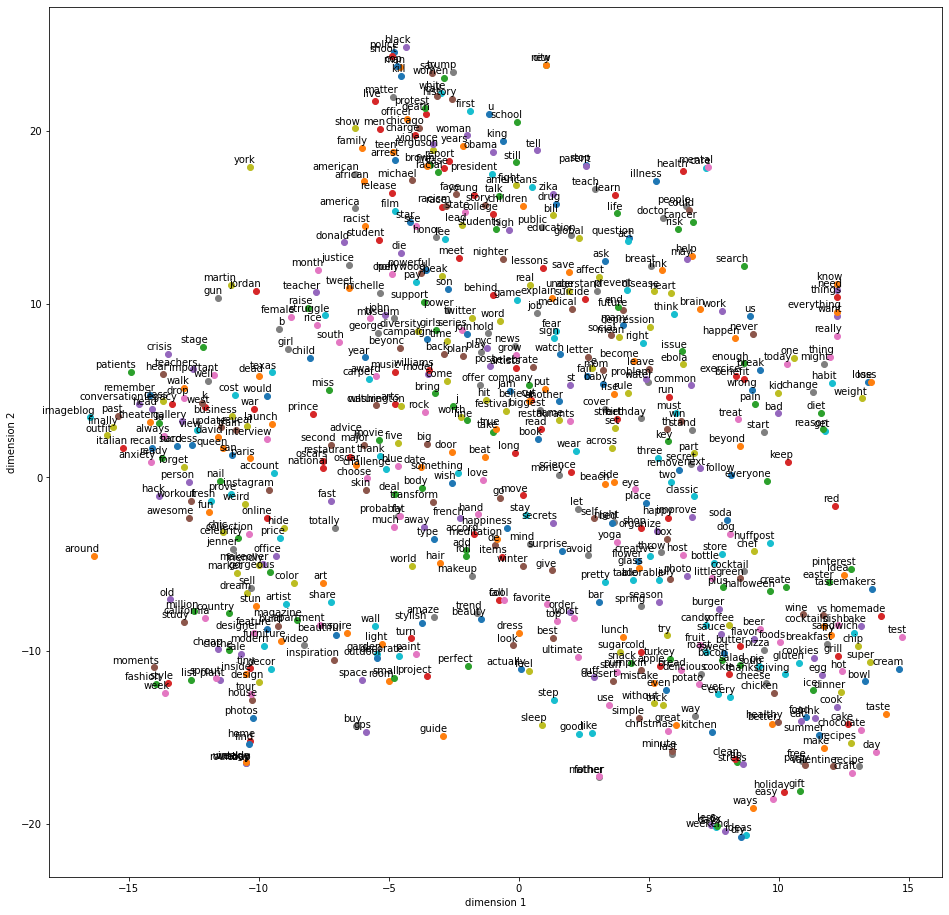

In [43]:
# Words that occur atleast 50 times
model = Word2Vec(all_words, window=20, min_count=50, workers=4)
tsne_plot()

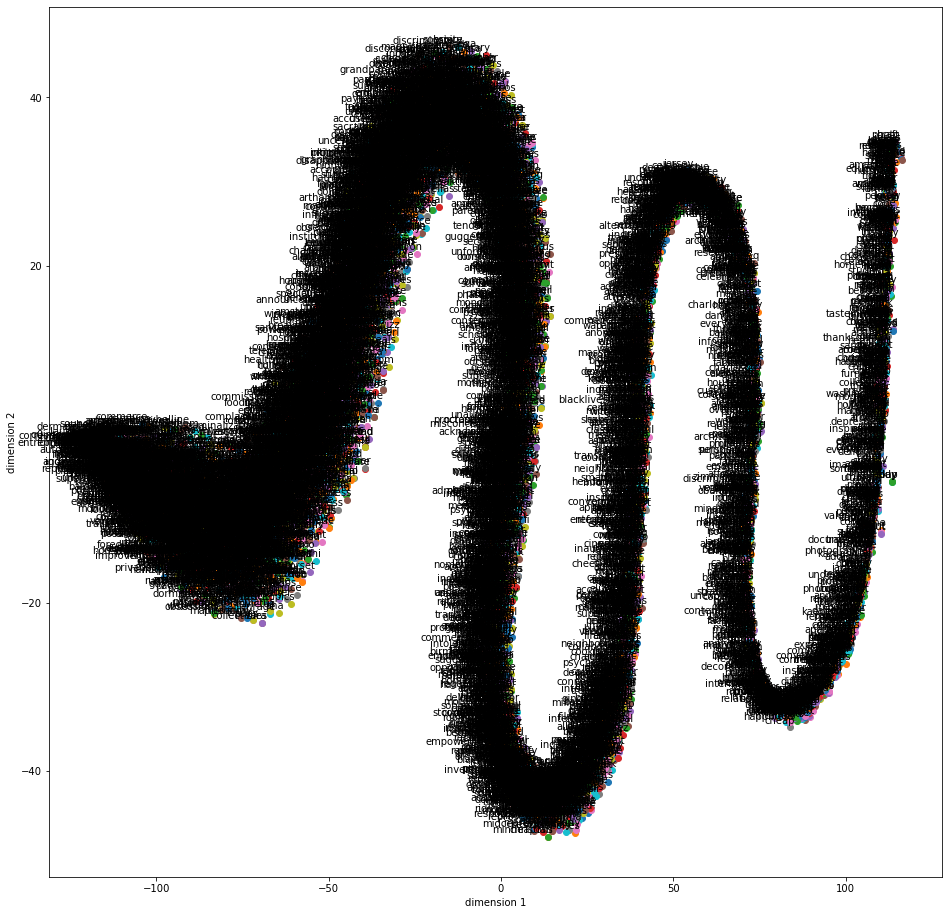

In [44]:
# Words that occur atleast 2 times
model = Word2Vec(all_words, window=20, min_count=2, workers=4)
tsne_plot()

It gets more and more difficult to read as the size of dataset increases 😵   

Hence, for __semantic retention__ and better inferences, we will plot only the __similar words__ to a chosen key.   

Word2Vector provides us with an inbuilt functionality to give the list of top similar words with respect to the cosine-distance💫    

In [45]:
model.wv.most_similar('atlanta')

[('racist', 0.9995906949043274),
 ('president', 0.9995899796485901),
 ('church', 0.9995899796485901),
 ('woman', 0.9995883703231812),
 ('call', 0.999577522277832),
 ('death', 0.9995761513710022),
 ('film', 0.9995705485343933),
 ('honor', 0.9995699524879456),
 ('protest', 0.9995638728141785),
 ('talk', 0.9995586276054382)]

In [46]:
keys = ['atlanta', 'holiday', 'health', 'introvert']

# this array will contain the vectors(dimension 100) and the labels
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [47]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

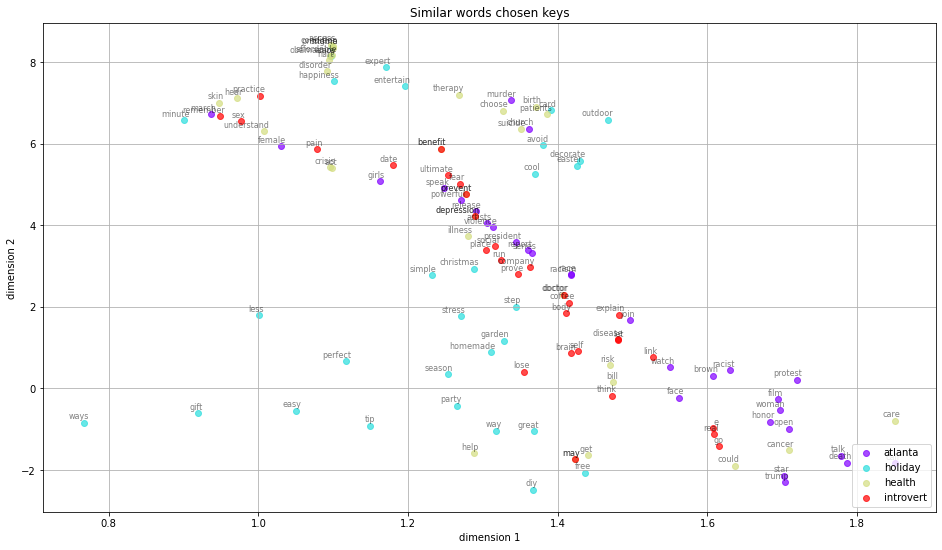

In [48]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    plt.xlabel("dimension 1")
    plt.ylabel("dimension 2")
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words chosen keys', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

## Topic Modeling

Topic modeling is a form of text mining, a way of identifying patterns in a corpus. You take your corpus and run it through a tool which groups words across the corpus into ‘topics’.

## Latent Dirichlet Allocation (LDA)

__Latent Dirichlet Allocation (LDA)__ and LSA are based on the same underlying assumptions: the distributional hypothesis, (i.e. similar topics make use of similar words) and the statistical mixture hypothesis (i.e. documents talk about several topics) for which a statistical distribution can be determined. The purpose of LDA is mapping each document in our corpus to a set of topics which covers a good deal of the words in the document.

![alt text](Schematic-of-LDA-algorithm.png "Schematic of LDA algorithm (D. Buenaño-Fernandez et al.  2020)")

In [54]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): 
    output = []        
    for sent in texts:              
        doc = nlp(" ".join(sent))                             
        output.append([token.lemma_ for token in doc if 
        token.pos_ in allowed_postags])        
    return output
# function to remove stopwords 
def remove_stopwords(rev):     
    rev_new = " ".join([i for i in rev if i not in stop_words])      
    return rev_new 

In [58]:
# remove short words (length < 3) 
df['headline_cleaned'] = df['headline_cleaned'].apply(lambda x: ' '.join([w for 
                   w in x.split() if len(w)>2])) 
# remove stopwords from the text 
headline = [remove_stopwords(r.split()) for r in df['headline_cleaned']] 
# make entire text lowercase 
headline = [r.lower() for r in headline]

In [59]:
tokenized_headline = pd.Series(headline).apply(lambda x: x.split())
print(tokenized_headline[1])

['historic', 'victory', 'barbados', 'elects', 'first', 'female', 'prime', 'minister']


In [60]:
headline_2 = lemmatization(tokenized_headline)
print(headline_2[1]) # print lemmatized headline

['historic', 'victory', 'barbado', 'elect', 'first', 'female', 'prime', 'minister']


In [84]:
ntopics = 5
dictionary = corpora.Dictionary(headline_2)
doc_term_matrix = [dictionary.doc2bow(headline) for lyric in headline_2]

In [85]:
import time
t0 = time.time()
# Creating the object for LDA model using gensim library 
LDA = gensim.models.ldamodel.LdaModel 
# Build LDA model 
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary,                                     
                num_topics=ntopics, random_state=100, chunksize=1000,                                     
                passes=50)
print('\nThe LDA_MODEL dataset done in '+'%s seconds'% (time.time() - t0))


The LDA_MODEL dataset done in 10414.950634002686 seconds


In [86]:
## word lists
for i in range(0,ntopics):
    temp = lda_model.show_topic(i, 10)
    terms = []
    for term in temp:
        terms.append(term)
    print("\nTop 10 terms for topic #" + str(i) + ": "+ ", ".join([i[0] for i in terms]))
   


Top 10 terms for topic #0: story, love, breaking, need, strong, sorry, life, soulmate, ocd, depression

Top 10 terms for topic #1: story, life, strong, sorry, love, breaking, need, naked, point, farc

Top 10 terms for topic #2: story, life, sorry, need, strong, breaking, love, magic, day, eat

Top 10 terms for topic #3: story, love, need, breaking, sorry, strong, life, dinner, label, breathe

Top 10 terms for topic #4: story, need, life, breaking, love, strong, sorry, balance, greatestmomentsinblacktwitterhistory, fondue


In [87]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(ntopics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [88]:
get_lda_topics(lda_model, ntopics)

Topic # 01   Topic # 02   Topic # 03 Topic # 04  \
0                                  story        story        story      story   
1                                   love         life         life       love   
2                               breaking       strong        sorry       need   
3                                   need        sorry         need   breaking   
4                                 strong         love       strong      sorry   
5                                  sorry     breaking     breaking     strong   
6                                   life         need         love       life   
7                               soulmate        naked        magic     dinner   
8                                    ocd        point          day      label   
9                             depression         farc          eat    breathe   
10                               datelob      datelob    mortality      worry   
11                              campaign        nurse        negro      bored   
12                            diabetical        bully        farro    anxiety   
13  greatestmomentsinblacktwitterhistory     baaaaack    guacamole       fool   
14                           hbcusmatter      furnace      sadness      light   
15                               stretch  klinghoffer       boring      farro   
16                                  hear         earn  remembering   mixology   
17                                   see   disability         lame       ball   
18                                  farc      retreat  immortality       move   
19                                boring       upside        llama        day   

                              Topic # 05  
0                                  story  
1                                   need  
2                                   life  
3                               breaking  
4                                   love  
5                                 strong  
6                                  sorry  
7                                balance  
8   greatestmomentsinblacktwitterhistory  
9                                 fondue  
10                             lightness  
11                          surveillance  
12                                skiing  
13                              backyard  
14                           hbcusmatter  
15                              bullying  
16                             remainder  
17                             guacamole  
18                            diabetical  
19                               killing

In [89]:
# Assign each document to most prevalent topic
lda_topic_assignment = [max(p,key=lambda item: item[1]) for p in lda_model[doc_term_matrix]]

In [90]:
 Topic_list_cln =[p[0] for p in lda_topic_assignment ]

In [91]:
df["Topic_LDA"] = Topic_list_cln

### Non-negative Matrix Factorization (NMF)
__Non-Negative Matrix Factorization__ is a statistical method that helps us to reduce the dimension of the input corpora or corpora. Internally, it uses the factor analysis method to give comparatively less weightage to the words that are having less coherence. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

![alt text](5-Figure1-1.png "Illustration of NMF model for topic modeling. (Kelsey MacMillan, James D. Wilson. 2017)")

In [92]:
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
cln_counts = vectorizer.fit_transform(df['headline_cleaned'])

In [93]:
transformer_cln = TfidfTransformer(smooth_idf=False);
x_tfidf_cln = transformer_cln.fit_transform(cln_counts);

In [94]:
xtfidf_norm_cln = normalize(x_tfidf_cln, norm='l1', axis=1)

In [95]:
#obtain a NMF model.
model_cln = NMF(n_components=ntopics, random_state = 50,init='nndsvd');
#fit the model
W_mat_cln = model_cln.fit_transform(xtfidf_norm_cln)
H_mat_cln = model_cln.components_

In [96]:
df["Topic_NMF"] = np.argmax(W_mat_cln, axis =1)

In [97]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(ntopics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [98]:
get_nmf_topics(model_cln, ntopics)

Topic # 01 Topic # 02 Topic # 03 Topic # 04 Topic # 05
0         the        you     photos  imageblog        how
1         day       your    recipes        the       make
2        best        for       home     rachel       with
3      recipe        and        for       doug      video
4         and       what        and      bruce      clean
5       world        are       best   seinfeld       from
6         art       ways    dessert      david       your
7         new      about       that    michael       home
8       craft        why    vintage     thomas    without
9        most       with    roundup       maya       cook
10       from       that     summer       neal        can
11      power        can      finds      chris   cocktail
12    america       this       ebay      wayne     recipe
13        for       life     weekly       mike    perfect
14        top       know       food      white     remove
15      black       need       more      brown        get
16       week     should   birthday      march       like
17       food     things       make       alex       cake
18        way        new      house      julia        use
19       with       love  breakfast      robin  organized

## Vizualisation using Wordcloud

In [99]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS) 

### For LDA Topics

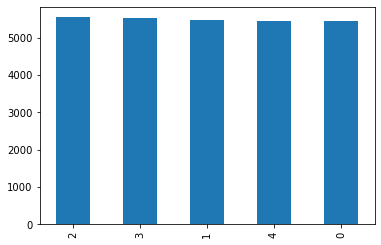

In [100]:
df['Topic_LDA'].value_counts().plot(kind = 'bar')
plt.show()

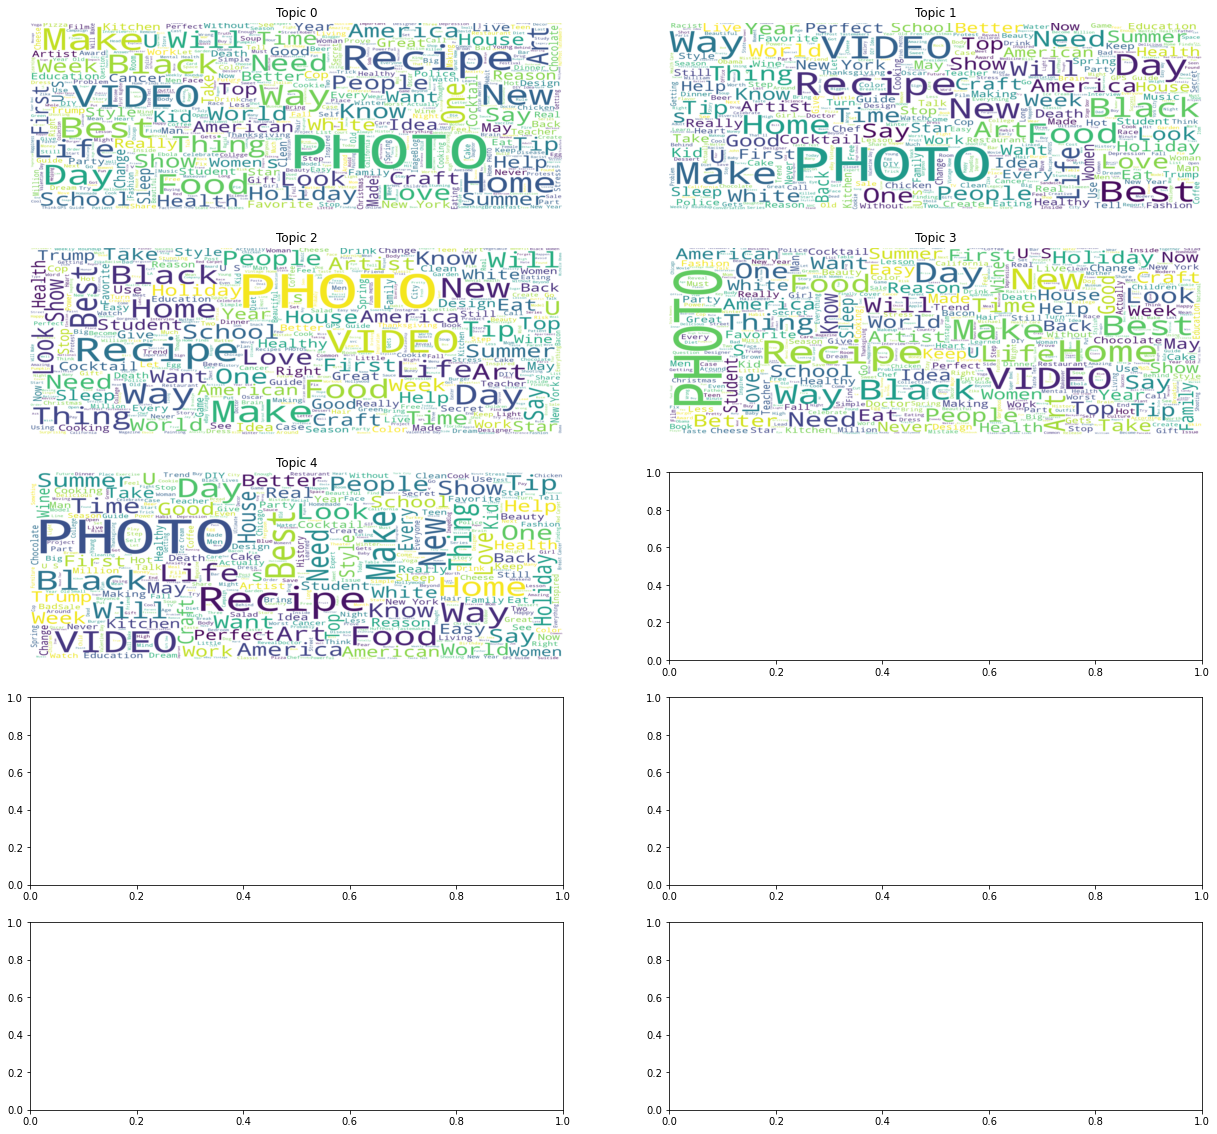

In [101]:
fig, axs = plt.subplots(5,2, figsize=(21,20))

for item  in enumerate(list(df['Topic_LDA'].unique())):
    wc = WordCloud(background_color="White",stopwords = stopwords,
               max_words=1000, max_font_size= 200,  width=1600, height=800,min_font_size = 10)
    wc.generate(" ".join(df[df['Topic_LDA']== item[1]]['headline']))
    
    axs[item[1]//2, item[1]%2].set_title("Topic %d" % item[1])
    axs[item[1]//2, item[1]%2].imshow(wc, aspect='auto', interpolation='bilinear')
    axs[item[1]//2, item[1]%2].axis("off")

### For NMF Topics

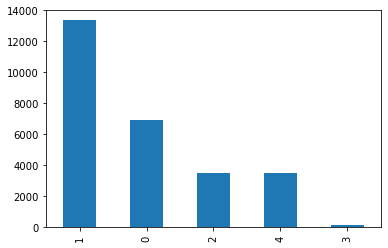

In [102]:
df['Topic_NMF'].value_counts().plot(kind = 'bar')
plt.show()

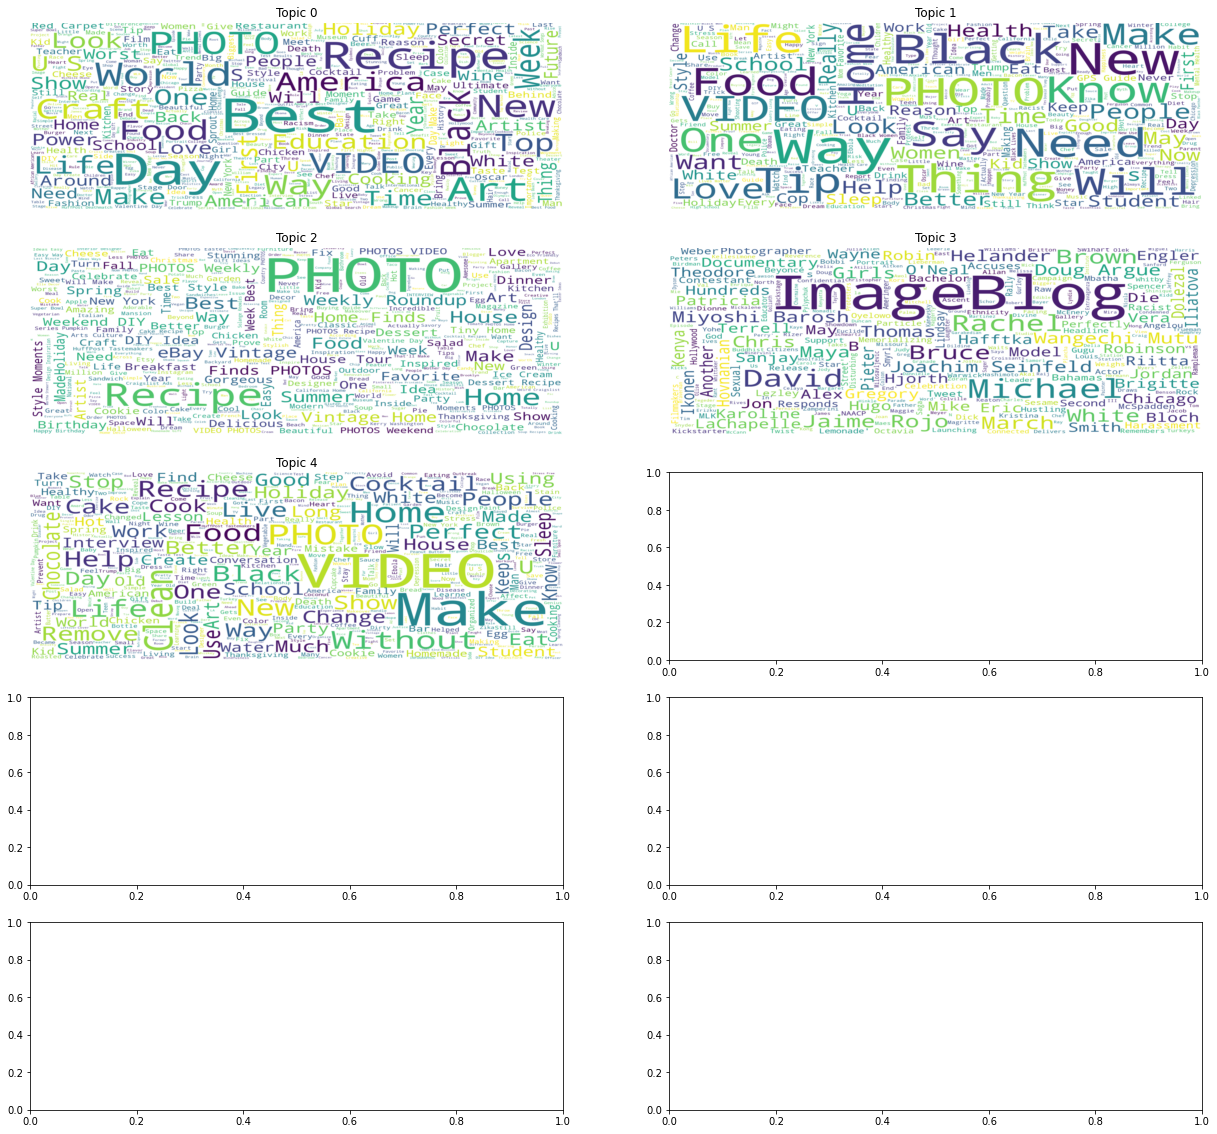

In [103]:
fig, axs = plt.subplots(5,2, figsize=(21,20))

for item  in enumerate(list(df['Topic_NMF'].unique())):
    wc = WordCloud(background_color="White",stopwords = stopwords,
               max_words=1000, max_font_size= 200,  width=1600, height=800,min_font_size = 10)
    wc.generate(" ".join(df[df['Topic_NMF']== item[1]]['headline']))
    
    axs[item[1]//2, item[1]%2].set_title("Topic %d" % item[1])
    axs[item[1]//2, item[1]%2].imshow(wc, aspect='auto', interpolation='bilinear')
    axs[item[1]//2, item[1]%2].axis("off")

## Challenge

I have done most of this work using the news headlines as they are shorter for in class study.  
Using the Top 3 Sections we have found earlier.   
Follow the same steps we have here using the Short Description columns. 